In [1]:
pip install brokenaxes

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import itertools as it
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
from brokenaxes import brokenaxes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [8]:
# Import inputs and outputs
inputs1 = np.load('initial_inputs.npy')
outputs1 = np.load('initial_outputs.npy')
inputs2 = np.load('initial_inputs2.npy')
outputs2 = np.load('initial_outputs2.npy')

# Concatenate inputs and outputs
inputs = np.concatenate((inputs1, inputs2), axis=0)
outputs = np.concatenate((outputs1, outputs2), axis=0)

#Import check
print(len(inputs1),len(inputs2),len(inputs))
print(len(outputs1),len(outputs2),len(outputs))


10 20 30
10 20 30


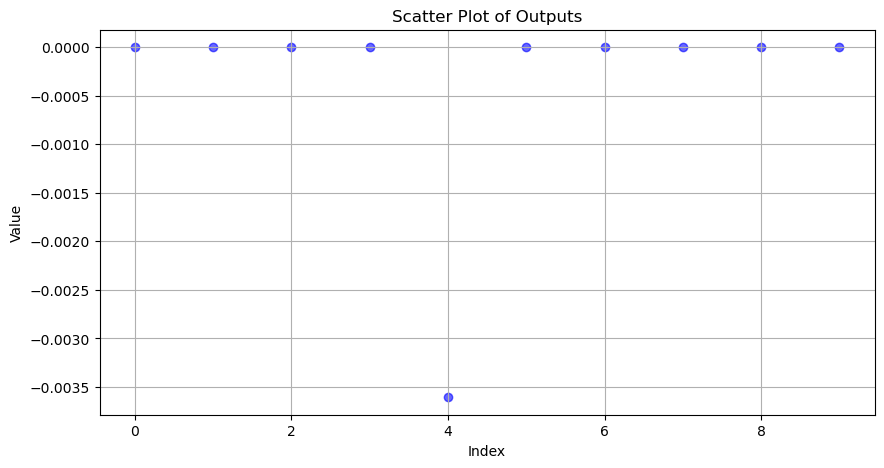

In [3]:
#visualise outputs
# Create indices for your outputs array
indices = np.arange(len(outputs))

plt.figure(figsize=(10, 5))  # Set the figure size
plt.scatter(indices, outputs, color='blue', alpha=0.6)  # Create a scatter plot
plt.title('Scatter Plot of Outputs')  # Set the title of the plot
plt.xlabel('Index')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.grid(True)  # Enable grid to make the plot easier to read
plt.show()  # Display the plot


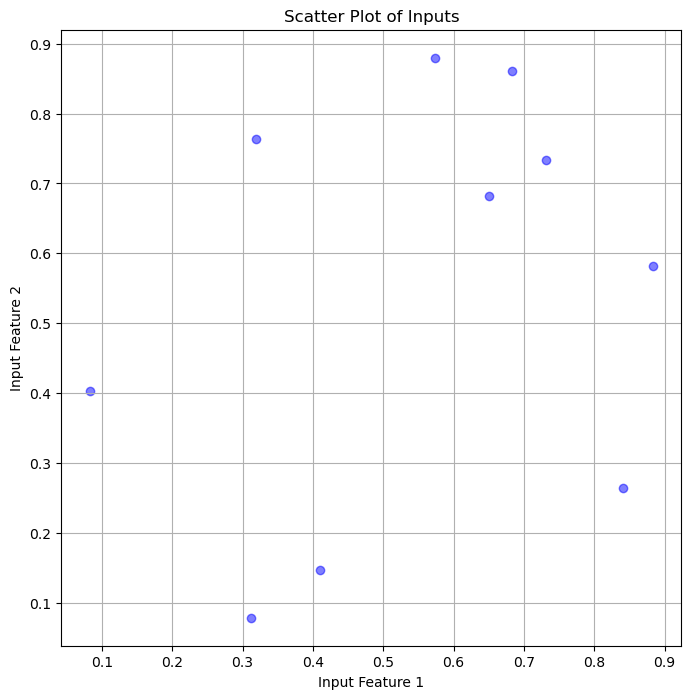

In [20]:
#visualise 2-D inputs
x = inputs[:, 0]  # x coordinates
y = inputs[:, 1]  # y coordinates

plt.figure(figsize=(8, 8))  # Set the figure size
plt.scatter(x, y, color='blue', alpha=0.5)  # Create a scatter plot
plt.title('Scatter Plot of Inputs')  # Set the title of the plot
plt.xlabel('Input Feature 1')  # Set the x-axis label
plt.ylabel('Input Feature 2')  # Set the y-axis label
plt.grid(True)  # Enable grid
plt.show()  # Display the plot




#set up functions
import numpy as np

def generate_grid(n, resolution):
    num_points = int(1 / resolution) + 1
    grid = np.mgrid[[slice(0, 1, 1j*num_points) for _ in range(n)]]
    grid = grid.reshape(n, -1).T  # Reshape to have n columns
    return grid

def generate_binary_combinations(n):
    # Use itertools.product to generate combinations and convert to a NumPy array
    combinations = np.array(list(itertools.product([0, 1], repeat=n)))
    return combinations


Added farthest point: [0.370202, 0.613480]
Added farthest point: [0.761177, 0.132366]
Added farthest point: [0.041254, 0.549744]
Added farthest point: [0.612057, 0.538263]
Added farthest point: [0.283702, 0.881480]
Added farthest point: [0.347101, 0.494240]
Added farthest point: [0.602529, 0.419632]
Added farthest point: [0.037000, 0.890000]
Added farthest point: [1.000000, 0.887500]
Added farthest point: [0.670588, 0.066183]


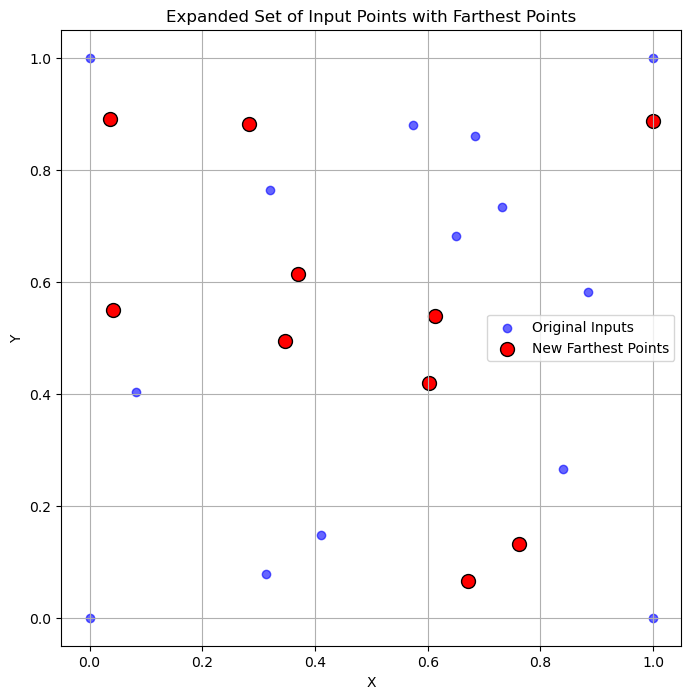

In [6]:

# Number of dimensions
n = 2  
corners = generate_binary_combinations(n)

# Initial set of inputs using corners to force choice of points farther from the surface of the hypothesis space
initial_np = np.load('initial_inputs.npy')
initial_inputs = np.vstack([initial_np, corners])  # Append to the inputs
inputs = initial_inputs.copy()  # Start with the initial inputs

# Number of farthest points to find
num_far_points = 10

# Resolution for the grid
resolution = 0.001

# Generate initial grid
grid_points = generate_grid(n, resolution)

# List to store newly added farthest points
new_points = []

for _ in range(num_far_points):
    tree = KDTree(inputs)  # Create a KD-tree for the current inputs
    distances = tree.query(grid_points)[0]  # Find distances to nearest input points
    max_index = np.argmax(distances)  # Index of the farthest point
    farthest_point = grid_points[max_index]  # The farthest point

    # Find the nearest point in inputs to the farthest_point
    tree_initial = KDTree(inputs)
    nearest_dist, nearest_index = tree_initial.query(farthest_point)  # Get nearest
    nearest_point = inputs[nearest_index]

    # Calculate the midpoint
    new_point = (farthest_point + nearest_point) / 2

    # Append to the inputs and new_points
    inputs = np.vstack([inputs, new_point])
    new_points.append(new_point)
    formatted_point = ', '.join(f"{coord:.6f}" for coord in new_point)
    print(f"Added farthest point: [{formatted_point}]")


# Loop to find and append farthest points
#for _ in range(num_far_points):
 #   tree = KDTree(inputs)  # Create a KD-tree for the current inputs
  #  distances = tree.query(grid_points)[0]  # Find distances to nearest input points
   # max_index = np.argmax(distances)  # Index of the farthest point
    #farthest_point = grid_points[max_index]  # The farthest point
    
    #inputs = np.vstack([inputs, ????])  # Append to the inputs
    #new_points.append(???)  # Store new point separately
    #formatted_point = ', '.join(f"{coord:.6f}" for coord in farthest_point_rounded)
    #print(f"Added farthest point: [{formatted_point}]")

# Visualization
plt.figure(figsize=(8, 8))
plt.scatter(initial_inputs[:, 0], initial_inputs[:, 1], color='blue', label='Original Inputs', alpha=0.6)
if new_points:
    new_points = np.array(new_points)
    plt.scatter(new_points[:, 0], new_points[:, 1], color='red', label='New Farthest Points', edgecolors='k', s=100)
plt.title('Expanded Set of Input Points with Farthest Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


#### BEGIN SECOND PHASE - RUN FROM HERE
Move from selecting semi-random exploration to more targetted exploration using Gaussian optmisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import itertools as it
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
from brokenaxes import brokenaxes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from brokenaxes import brokenaxes

In [3]:
# Import inputs and outputs
inputs1 = np.load('initial_inputs.npy')
outputs1 = np.load('initial_outputs.npy')
inputs2 = np.load('initial_inputs2.npy')
outputs2 = np.load('initial_outputs2.npy')

# Concatenate inputs and outputs
inputs = np.concatenate((inputs1, inputs2), axis=0)
outputs = np.concatenate((outputs1, outputs2), axis=0)

#Import check
print(len(inputs1),len(inputs2),len(inputs))
print(len(outputs1),len(outputs2),len(outputs))


10 20 30
10 20 30


In [4]:
new_inputs = np.array([[0.370202,0.61348],[0.761177, 0.132366],[0.041254,0.549744],[0.612057,0.538263],[0.877551,0.795918],[0.571429, 0.367347],[0.918367, 0.816327],[0.387755, 0.999999],[0.816327, 0.693878],[0.591837, 0.612245],[0.591837, 0.612245],[0.59596,0.616162],[0.596597, 0.615616]])

In [5]:
new_outputs = np.array([-2.84227240516847E-29,1.5153761275003795e-139,4.66794878596712E-113,-1.98260272302875E-06,-4.40392658176033E-63,-1.16710145824222E-18,5.06241425096598e-84,8.81029254604299e-137,-1.96403615544697E-28,0.012347304702457419, 0.012347304702457419,0.066640529538396, 0.0751453942544351])

In [6]:
inputs = np.append(inputs, new_inputs, axis = 0)
outputs = np.append(outputs, new_outputs)


In [7]:
print(len(inputs))

43


In [8]:
print(np.max(outputs))

0.0751453942544351


#### Visualise new inputs

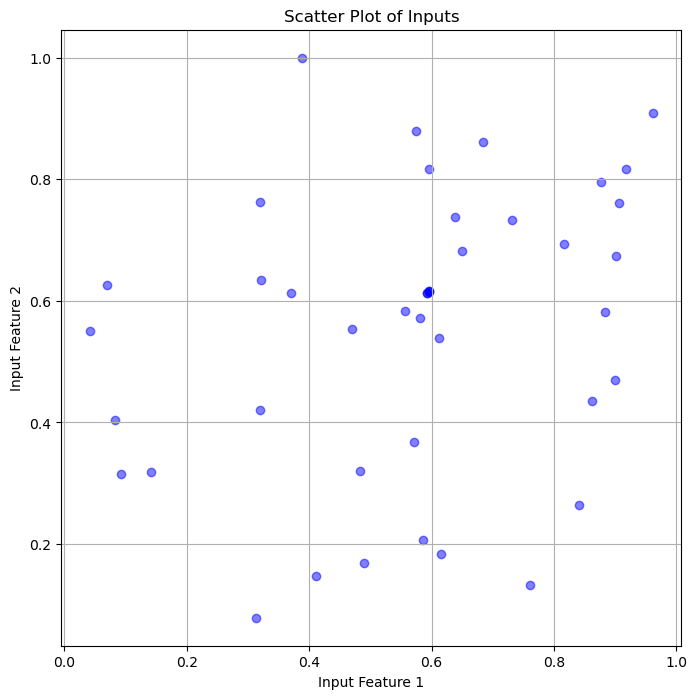

In [9]:
#visualise 2-D inputs
x = inputs[:, 0]  # x coordinates
y = inputs[:, 1]  # y coordinates

plt.figure(figsize=(8, 8))  # Set the figure size
plt.scatter(x, y, color='blue', alpha=0.5)  # Create a scatter plot
plt.title('Scatter Plot of Inputs')  # Set the title of the plot
plt.xlabel('Input Feature 1')  # Set the x-axis label
plt.ylabel('Input Feature 2')  # Set the y-axis label
plt.grid(True)  # Enable grid
plt.show()  # Display the plot


#### Visualise New Inputs and Outputs

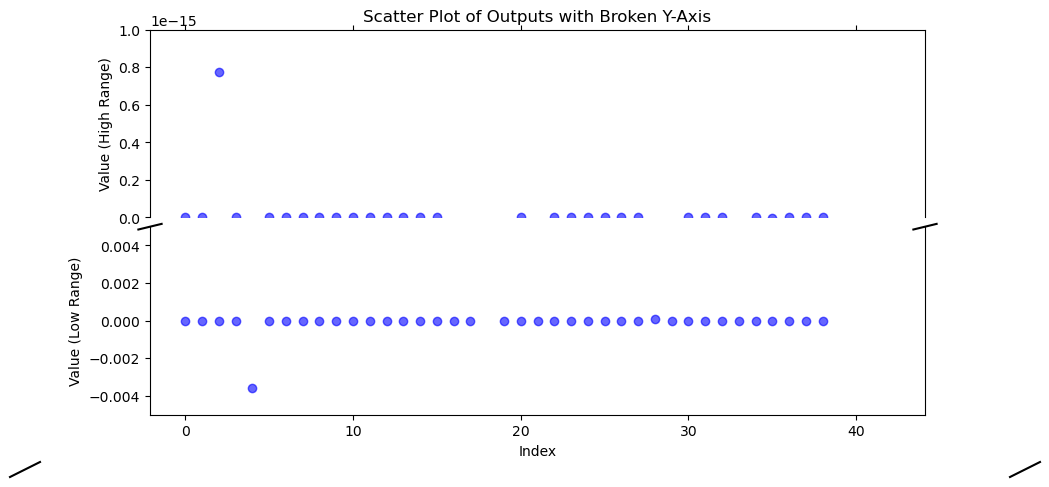

In [10]:
# Create indices for your outputs array
indices = np.arange(len(outputs))

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Plot the same data on both axes
ax.scatter(indices, outputs, color='blue', alpha=0.6)
ax2.scatter(indices, outputs, color='blue', alpha=0.6)

# zoom-in / limit the view to different parts of the data
ax.set_ylim(1e-40, 1e-15)  # upper part
ax2.set_ylim(-5e-3, 5e-3)  # lower part

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# draw the break marks
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=fig.transFigure, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set_title('Scatter Plot of Outputs with Broken Y-Axis')
ax2.set_xlabel('Index')
ax.set_ylabel('Value (High Range)')
ax2.set_ylabel('Value (Low Range)')

plt.show()


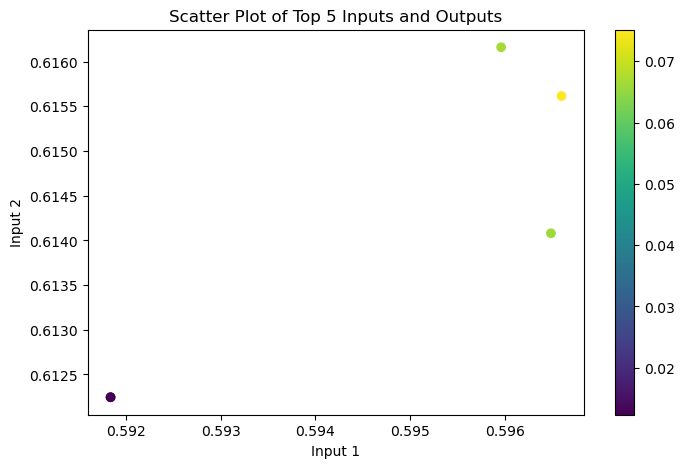

In [11]:
# Define the number of top values to show
top_X = 5

# Replace with your desired number of top values

# Get the indices of the top X outputs
top_indices = np.argsort(outputs)[-top_X:]

# Select the top X inputs and outputs
top_inputs = inputs[top_indices]
top_outputs = outputs[top_indices]

# Plot the top X data
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
scatter = ax.scatter(top_inputs[:, 0], top_inputs[:, 1], c=top_outputs, cmap='viridis')
plt.colorbar(scatter, ax=ax)
plt.title(f'Scatter Plot of Top {top_X} Inputs and Outputs')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.show()


/Users/iangosling/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.596597-0.615616


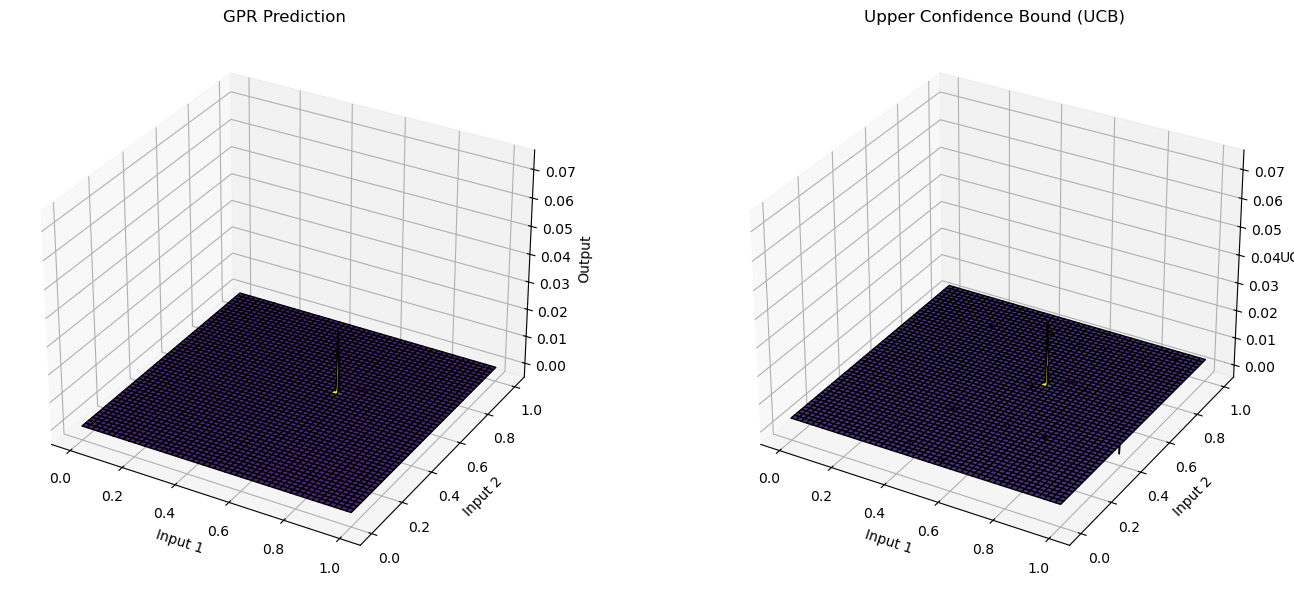

In [12]:
# Define the kernel
kernel = C(1.0, (1e-7, 1e1)) * RBF(1.0, (1e-7, 1e1))

# Create and train the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40)
gpr.fit(inputs, outputs)

# Generate test points
x1 = np.linspace(0, 1, 1000)
x2 = np.linspace(0, 1, 1000)
x1x2 = np.array([[x, y] for x in x1 for y in x2])

# Predict using the Gaussian Process
y_pred, sigma = gpr.predict(x1x2, return_std=True)

# Calculate UCB
kappa = 0.3  # Exploration-exploitation trade-off parameter
ucb = y_pred + kappa * sigma

# Identify the optimal inputs
max_ucb_index = np.argmax(ucb)
optimal_input = x1x2[max_ucb_index]

# Round the optimal inputs to six decimal places
optimal_input_rounded = np.round(optimal_input, 6)

# Print the optimal inputs
formatted_query = [f'{item:.6f}' for item in optimal_input_rounded]
formatted_output = f'{formatted_query[0]}-{formatted_query[1]}'
print(formatted_output)

# Reshape predictions for plotting
x1, x2 = np.meshgrid(x1, x2)
y_pred = y_pred.reshape(x1.shape)
ucb = ucb.reshape(x1.shape)

# Plot the results
fig = plt.figure(figsize=(15, 6))

# Subplot 1: GPR Prediction
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x1, x2, y_pred, cmap=cm.viridis, edgecolor='k')
ax1.set_title('GPR Prediction')
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_zlabel('Output')

# Subplot 2: UCB
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1, x2, ucb, cmap=cm.viridis, edgecolor='k')
ax2.set_title('Upper Confidence Bound (UCB)')
ax2.set_xlabel('Input 1')
ax2.set_ylabel('Input 2')
ax2.set_zlabel('UCB')

plt.tight_layout()
plt.show()

### CHANGE LOG
#### 22ND JUNE 
* Debated whether to increase lower confidence bound to 1 x 10**-6 and did so
#### 7th JULY 
* Added in new data and cut reduced kappa to 0.4
#### 13th JULY 
* Reduced kappa to 0.2  and increased linspace to 100
#### 13th JULY 
* Increased linspace to 1000